# Importing libraries


In [1]:

import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Some personal functions

In [2]:
def percentageMissing(data):
    total_rows = data.shape[0]
    columns = {}
    for i in data.columns:
        missing = data[i].isna().sum()
        percentage = (missing/total_rows) * 100
        if percentage > 0:
            columns[i] = percentage
        else:
            pass
    missing = pd.DataFrame(columns,index=['Percentage missing (%)']).T.sort_values(by = ['Percentage missing (%)'],ascending=False)

    return display(missing)


def categorize_week(day):
    if day <= 8:
        return 1
    elif day <= 15:
        return 2
    elif day <= 22:
        return 3
    else:
        return 4
  

def correct_year(year_str):
    year = int(year_str)
    if year > 24:
        return year
    else:
        return year + 2000


def choose_season(month):
    if month in (3,4,5):
        return 'spring'
    if month in (6,7,8):
        return 'summer'
    if month in (9,10,11):
        return 'autum'
    else:
        return 'winter'


def aerosol(a):
    if a <= -2.8:
        return 4
    elif a -2.8 and a < -1:
        return 3
    elif a >= -1 and a <= 0:
        return 2
    elif a > 0 and a < 1:
        return 1
    else:
        return 0

# Importing data

In [3]:
train_csv = pd.read_csv('Train.csv')
test_csv = pd.read_csv('Test.csv')
train_data = pd.DataFrame(train_csv)
test_data = pd.DataFrame(test_csv)

# Initial look at data

In [4]:
train_data.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [5]:
test_data.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,ID_2MYNQS,1/1/19,PD03,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819
1,ID_P4U5WU,1/1/19,TV03,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790
2,ID_U4KWPK,1/1/19,X5561,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,ID_QGSNTZ,1/1/19,X5953,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006
4,ID_GHSZ6K,1/1/19,X6701,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840


In [6]:
train_data.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [7]:
test_data.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
count,6576.000000,6576.000000,6576.000000,3595.000000,5708.000000,5708.000000,5708.000000,5708.000000,3998.000000,5708.000000
mean,45.363205,10.489789,2.544018,299.394019,-1.273390,0.203512,0.000045,0.000135,0.000081,16673.339355
std,0.260667,1.306469,7.475326,11.034047,0.691949,0.269866,0.000012,0.000084,0.000067,3007.160286
min,45.131947,8.842165,0.000000,254.720000,-3.716866,0.000000,0.000013,0.000006,-0.000009,8614.512125
25%,45.151743,9.146666,0.000000,291.040000,-1.753032,0.013360,0.000034,0.000094,0.000041,14433.046735
50%,45.237853,10.398575,0.000000,300.900000,-1.363993,0.070884,0.000047,0.000111,0.000058,16714.003425
75%,45.582894,11.642394,0.000000,308.120000,-0.876478,0.296377,0.000056,0.000144,0.000097,19260.483658
max,45.836941,12.510362,103.227943,324.140000,2.474583,1.000000,0.000072,0.001454,0.000960,24424.343390


# Missing data

In [8]:
percentageMissing(train_data)
percentageMissing(test_data)

,Percentage missing (%)
LST,45.950753
NO2_trop,40.969463
AAI,14.869953
CloudFraction,14.869953
NO2_strat,14.869953
NO2_total,14.869953
TropopausePressure,14.869953
GT_NO2,5.235378


,Percentage missing (%)
LST,45.331509
NO2_trop,39.203163
AAI,13.199513
CloudFraction,13.199513
NO2_strat,13.199513
NO2_total,13.199513
TropopausePressure,13.199513


# Plots

## Locations

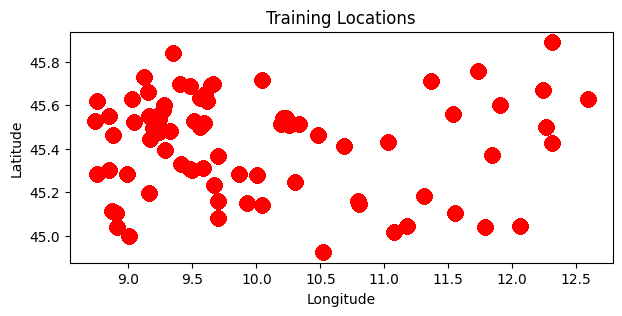

In [9]:
plt.figure(figsize=(7, 3))
plt.scatter(train_data['LON'], train_data['LAT'], c='r', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Locations')
plt.show()

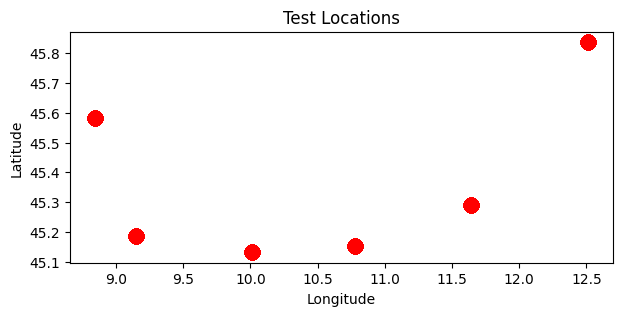

In [10]:
plt.figure(figsize=(7, 3))
plt.scatter(test_data['LON'], test_data['LAT'], c='r', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Locations')
plt.show()

## Distributions of features (Boxplots)

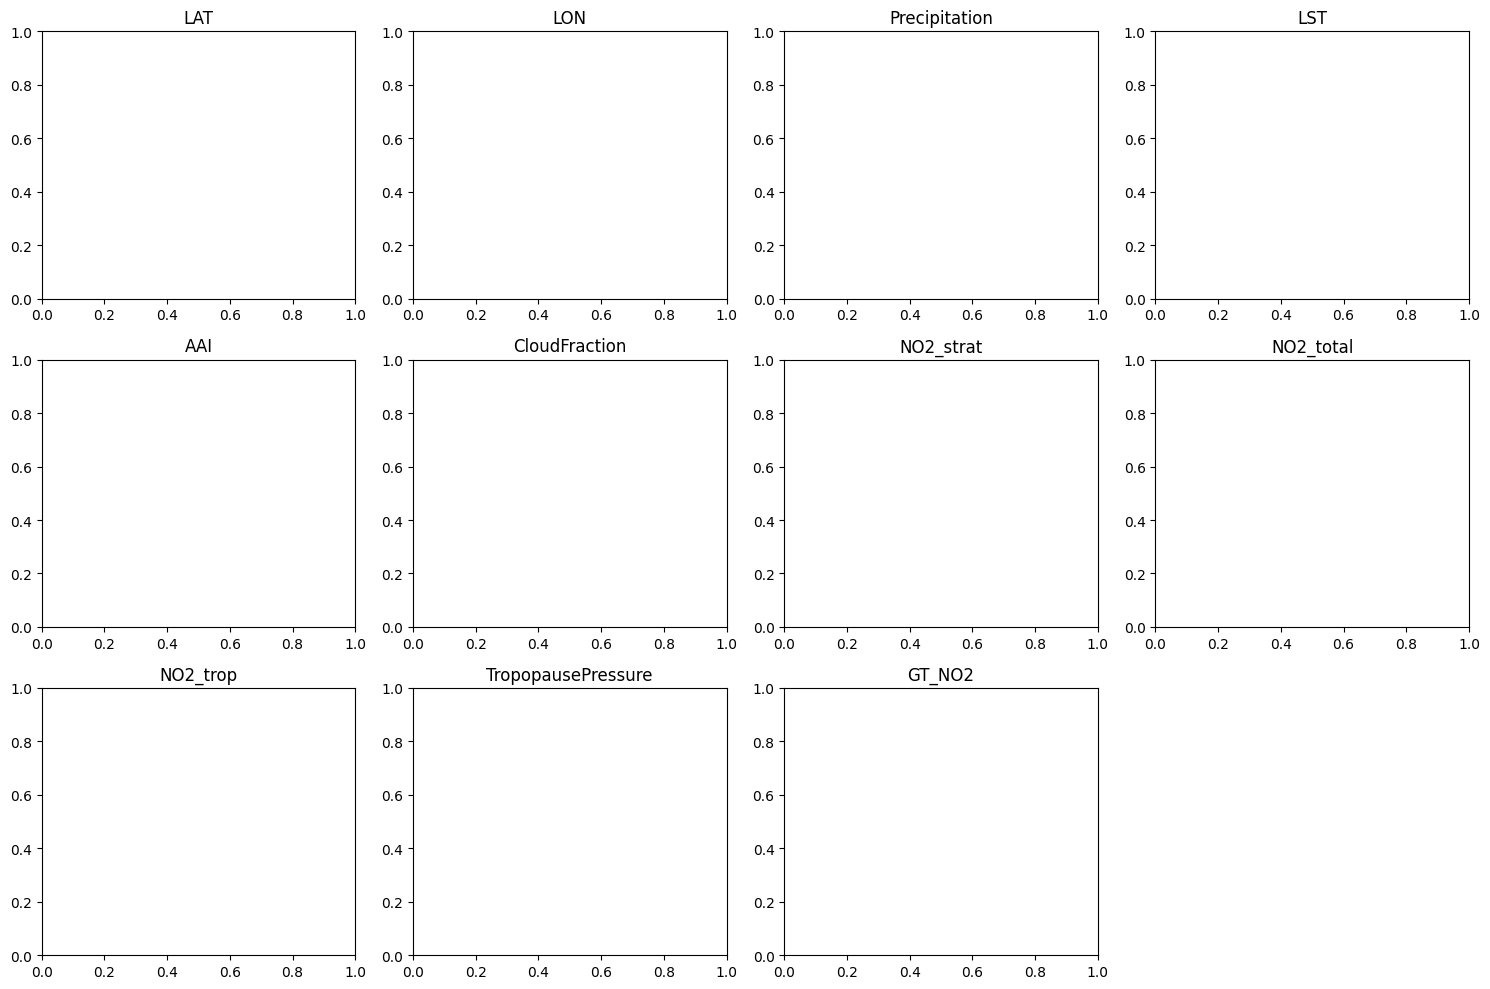

In [11]:
columns = [ 'LAT', 'LON', 'Precipitation', 'LST', 'AAI','CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop',
           'TropopausePressure', 'GT_NO2']
num_plots = len(columns)
n_cols = 4
n_rows = (num_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(columns):
    # sns.kdeplot(x=train_data[col], ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Scatter plots against GT_NO2

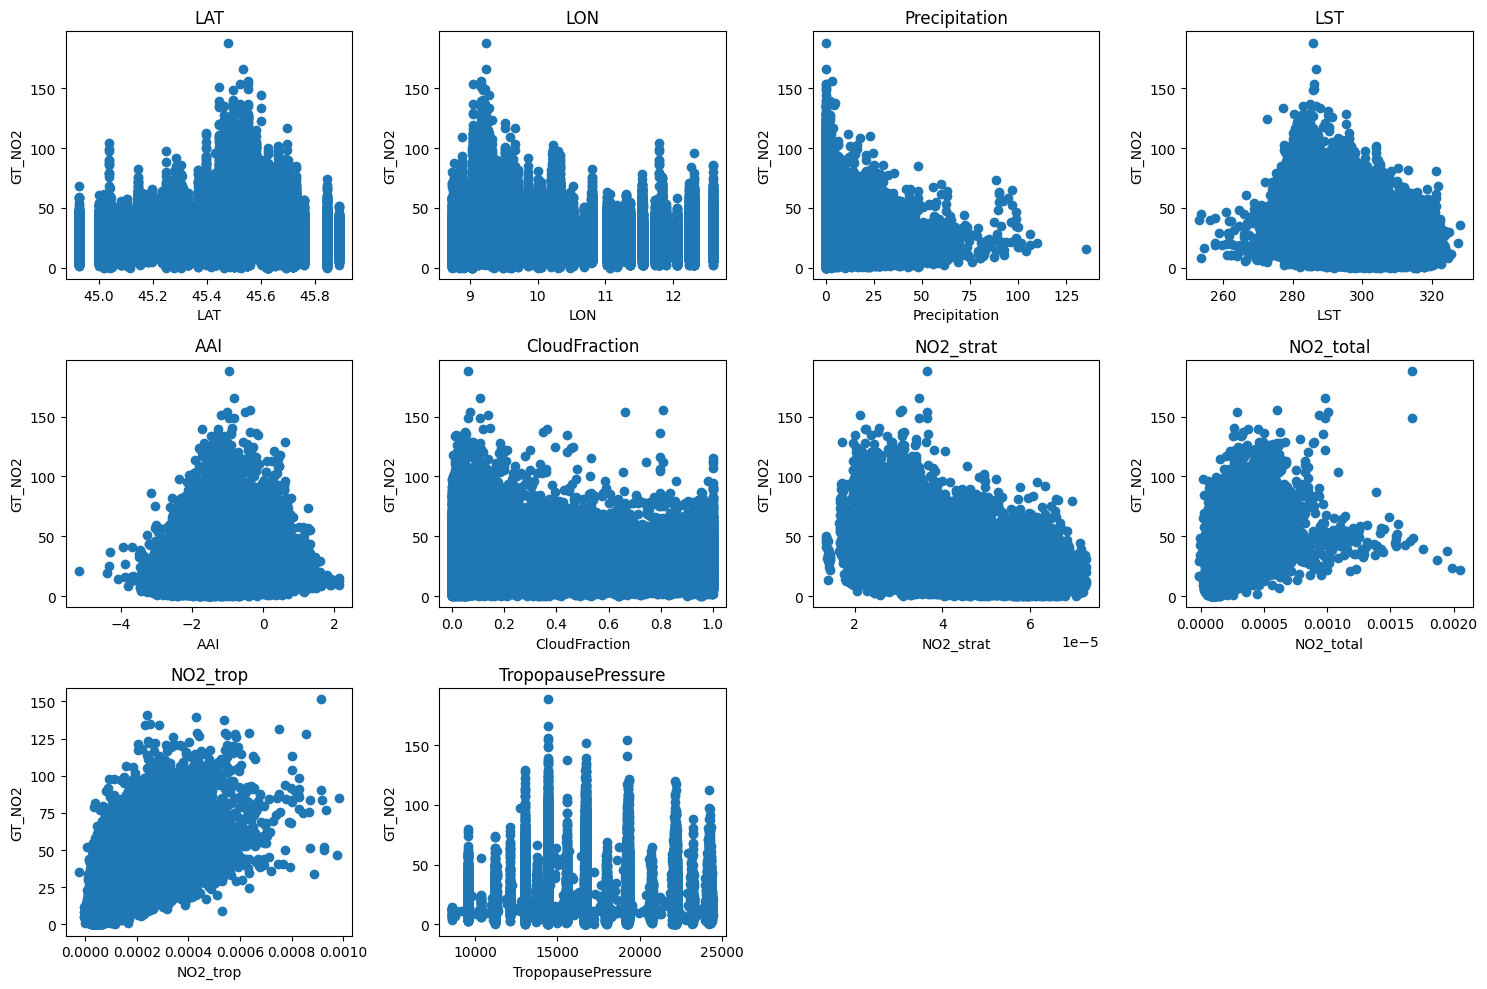

In [12]:
columns = ['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 
           'NO2_total', 'NO2_trop', 'TropopausePressure']

num_plots = len(columns)
n_cols = 4
n_rows = (num_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(columns):
    axs[i].plot(train_data[col], train_data['GT_NO2'], 'o')
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('GT_NO2')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Some new features and transformations

In [13]:
train_data['AAI_cat'] = train_data['AAI'].apply(aerosol)
test_data['AAI_cat'] = test_data['AAI'].apply(aerosol)

In [14]:
pattern = r'(\d{1,2})[/-](\d{1,2})[/-](\d{2,4})'
train_data['Month'] = train_data['Date'].str.extract(pattern,expand=False)[1]
train_data['Month'] = train_data['Month'].astype(float).astype(int)

test_data['Month'] = test_data['Date'].str.extract(pattern,expand=False)[0]
test_data['Month'] = test_data['Month'].astype(float).astype(int)

train_data['Day'] = train_data['Date'].str.extract(pattern,expand=False)[0]
train_data['Day'] = train_data['Day'].astype(float).astype(int)

test_data['Day'] = test_data['Date'].str.extract(pattern,expand=False)[1]
test_data['Day'] = test_data['Day'].astype(float).astype(int)

train_data['Year'] = train_data['Date'].str.extract(pattern, expand=False)[2]
train_data['Year'] = train_data['Year'].astype(int).apply(correct_year)
train_data['Year'] = train_data['Year'].astype(int)

test_data['Year'] = test_data['Date'].str.extract(pattern, expand=False)[2]
test_data['Year'] = test_data['Year'].astype(int).apply(correct_year)
test_data['Year'] = test_data['Year'].astype(int)

train_data['Week'] = train_data['Day'].apply(categorize_week)
test_data['Week'] = test_data['Day'].apply(categorize_week)


In [15]:
train_data['Season'] =train_data['Month'].apply(choose_season)
test_data['Season'] =test_data['Month'].apply(choose_season)


In [16]:
train_data['LON'] = np.radians(train_data['LON'])
train_data['LAT'] = np.radians(train_data['LAT'])

test_data['LON'] = np.radians(test_data['LON'])
test_data['LAT'] = np.radians(test_data['LAT'])

# Plots again

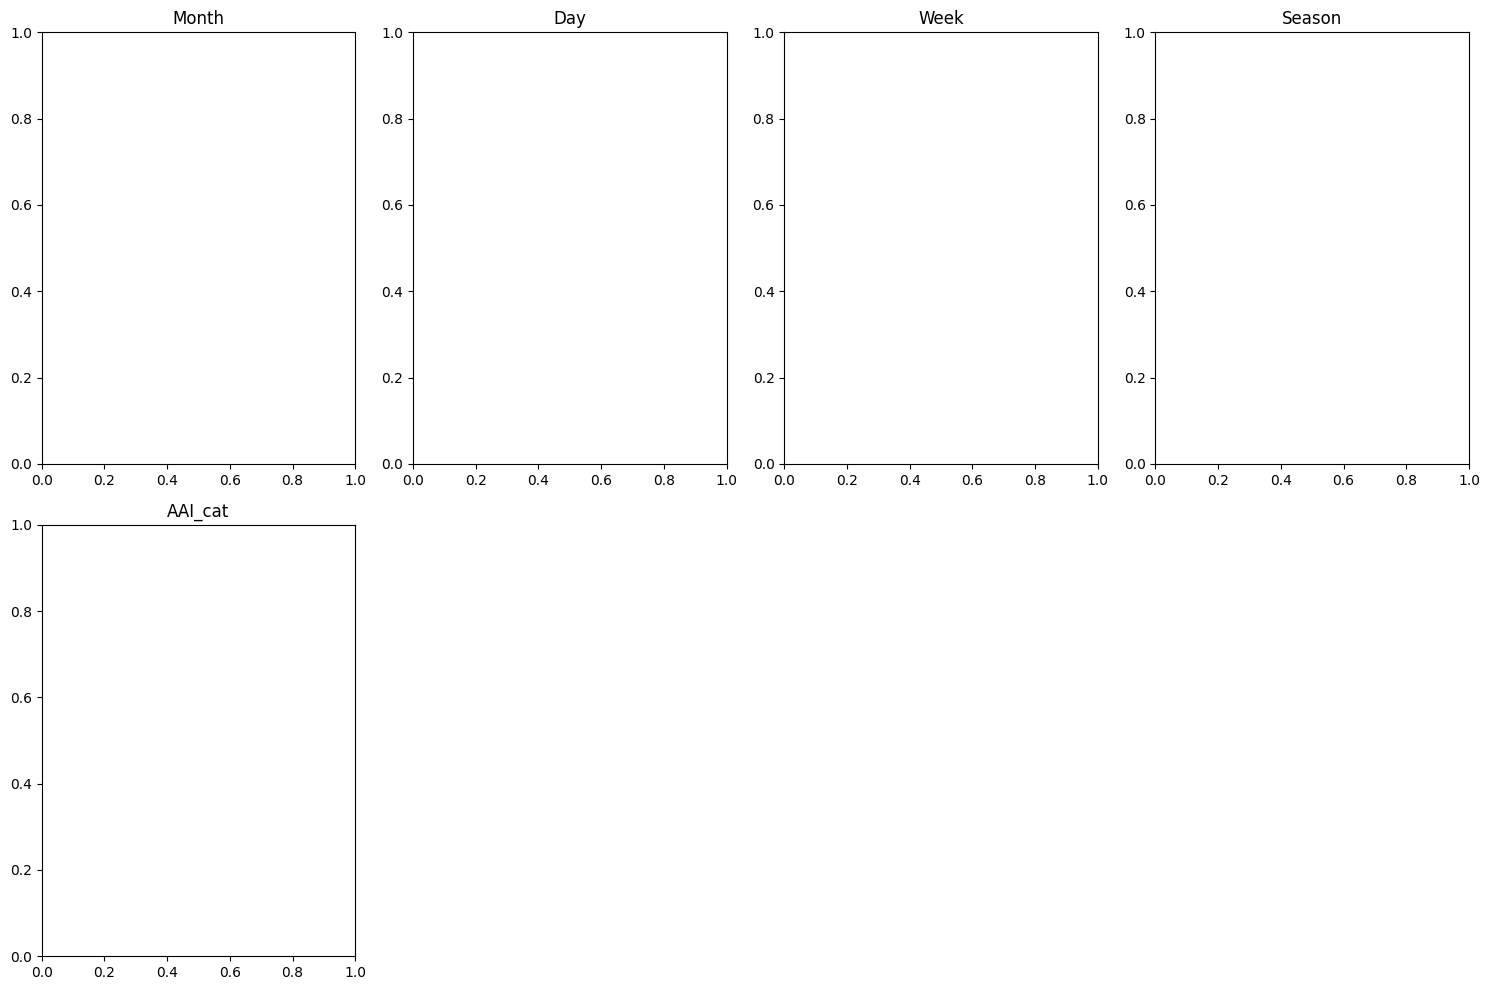

In [17]:
columns = ['Month','Day','Week','Season','AAI_cat']
num_plots = len(columns)
n_cols = 4
n_rows = (num_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(columns):
    # sns.histplot(x=train_data[col], ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# LABEL PREDICTION MODEL

In [18]:
clus_train1 = train_data.copy()
#clus_train1 = pd.get_dummies(clus_train1, columns=['Day' ,'Month','Week','Year'], prefix=['Day', 'Month','Week','Year'], drop_first=False)

clus_train1 = clus_train1.drop(['ID','ID_Zindi','Date'],axis = 1)

print(clus_train1.shape)

clus_train1 = clus_train1.interpolate(method='linear')

# Fill any remaining NaNs with forward-fill and backward-fill
clus_train1 = clus_train1.ffill().bfill()

(86584, 17)


In [19]:
from sklearn.cluster import KMeans
no2_scaled = np.array(clus_train1['GT_NO2']).reshape(-1,1)
a = KMeans(n_clusters=3,random_state=3).fit(no2_scaled)
j = pd.DataFrame(a.labels_,columns=['labels'])


clus_train1=clus_train1.reset_index()
cluster_df = pd.concat([clus_train1,j],axis=1)

d = dict(cluster_df['labels'].value_counts())
key = [val for val in d]
maximum,mid,minimum = key

cluster_df['labels']= cluster_df['labels'].replace(maximum,'l')
cluster_df['labels']= cluster_df['labels'].replace(mid,'m')
cluster_df['labels']= cluster_df['labels'].replace(minimum,'s')

cluster_df['labels']= cluster_df['labels'].replace('l',2)
cluster_df['labels']= cluster_df['labels'].replace('m',1)
cluster_df['labels']= cluster_df['labels'].replace('s',0)

cluster_df['labels'].value_counts()

labels
2    49988
1    28367
0     8229
Name: count, dtype: int64

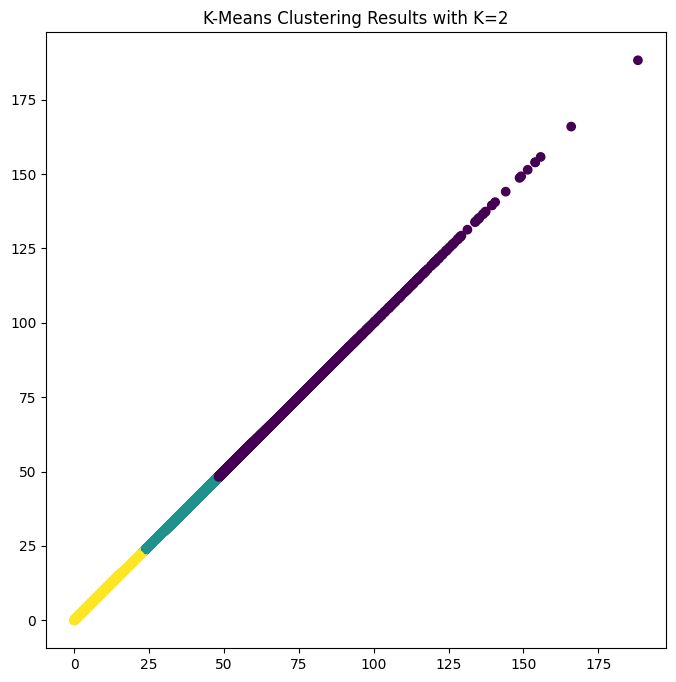

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(cluster_df['GT_NO2'], cluster_df['GT_NO2'], c=cluster_df.labels)
ax.set_title("K-Means Clustering Results with K=2")
plt.show()

In [21]:
cluster_df['LST_AAI_Interaction'] = cluster_df['LST'] * cluster_df['AAI']

cluster_df['AAI_NO2_Interaction'] = cluster_df['AAI'] * cluster_df['NO2_total']

cluster_df['AAI_Cloud_Ratio'] = cluster_df['AAI'] / (cluster_df['CloudFraction'] + 1e-6)

cluster_df['Cloud_NO2_Ratio'] = cluster_df['CloudFraction'] / (cluster_df['NO2_total'] + 1e-6)

cluster_df['NO2_LST_Interaction'] = cluster_df['NO2_total'] * cluster_df['LST']

cluster_df['Cloud_Albedo_Effect'] = cluster_df['CloudFraction'] * cluster_df['LST']

cluster_df['LSTsqr'] = cluster_df['LST'] ** 3

cluster_df['SUS'] = (cluster_df['NO2_trop'] + cluster_df['NO2_strat']) / cluster_df['NO2_total']
cluster_df['SUS_LST_Interaction'] = cluster_df['SUS'] * cluster_df['LST']

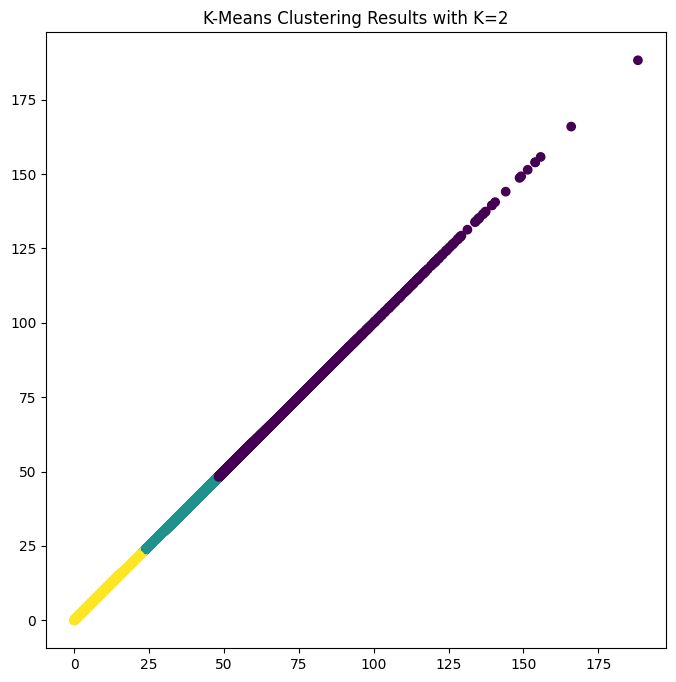

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(cluster_df['GT_NO2'], cluster_df['GT_NO2'], c=cluster_df.labels)
ax.set_title("K-Means Clustering Results with K=2")
plt.show()

In [23]:
x1 = cluster_df.drop(['index','LAT','Precipitation','GT_NO2','labels','Season'],axis=1)
from sklearn.preprocessing import StandardScaler
import numpy as np

# Exclude the 'Day', 'Week', 'Month', and 'Year' columns from scaling
columns_to_exclude = ['Day', 'Week', 'Month', 'Year','LON','AAI_cat']
columns_to_scale = x1.drop(columns_to_exclude,axis=1)
columns_excluded = x1[columns_to_exclude]
#columns_excluded = pd.get_dummies(columns_excluded, columns=['Season'], prefix=['Season'], drop_first=False)
# Initialize the scaler
scaler1 = StandardScaler()

# Fit and transform only the columns that need to be scaled
scaled_columns = scaler1.fit_transform(columns_to_scale)

# Combine the scaled columns with the unscaled 'Day', 'Week', 'Month', and 'Year' columns
x1 = np.concatenate([scaled_columns, columns_excluded.values], axis=1)


y1 = np.array(cluster_df['labels'])
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.2,random_state=59,stratify=y1)
print(x1_train.shape,y1_test.shape)

(69267, 22) (17317,)


In [24]:
from sklearn.tree import DecisionTreeClassifier
dtc= DecisionTreeClassifier(max_depth=11,random_state=5,criterion='entropy',class_weight='balanced')
dtc.fit(x1_train,y1_train)
linear_preds = dtc.predict(x1_test)
from sklearn import metrics
print(metrics.classification_report(y1_test,linear_preds))

              precision    recall  f1-score   support

           0       0.43      0.72      0.54      1646
           1       0.60      0.57      0.59      5673
           2       0.88      0.80      0.84      9998

    accuracy                           0.72     17317
   macro avg       0.64      0.70      0.65     17317
weighted avg       0.74      0.72      0.73     17317



In [25]:
to_predict_labels = list(columns_to_scale.columns) + columns_to_exclude
to_predict_labels

['LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure',
 'LST_AAI_Interaction',
 'AAI_NO2_Interaction',
 'AAI_Cloud_Ratio',
 'Cloud_NO2_Ratio',
 'NO2_LST_Interaction',
 'Cloud_Albedo_Effect',
 'LSTsqr',
 'SUS',
 'SUS_LST_Interaction',
 'Day',
 'Week',
 'Month',
 'Year',
 'LON',
 'AAI_cat']

# Actual Model Building

## MISSING VALUES & DUMMY VARIABLES

In [26]:
train1 = train_data.copy()
#train1 = train1.drop([72174, 81055])
#train1 = pd.get_dummies(train1, columns=['Day' ,'Month','Week','Year'], prefix=['Day', 'Month','Week','Year'], drop_first=False)

train1 = train1.drop(['ID','ID_Zindi','Date'],axis = 1)

print(train1.shape)



(86584, 17)


In [27]:
train1 = train1.interpolate(method='linear')
train1 = train1.ffill().bfill()

## Z-SCORE NORMALIZATION (OUTLIER REMOVAL)

In [28]:
from scipy import stats
import pandas as pd

# Compute Z-scores for the 'GT_NO2' column
z_scores = stats.zscore(train1['GT_NO2'])

# Define threshold for identifying outliers
threshold = 2

# Identify outliers
outliers = abs(z_scores) > threshold

# Remove rows where 'GT_NO2' is an outlier
train1 = train1[~outliers]

# Display the first few rows of the updated DataFrame
train1.shape

(82545, 17)

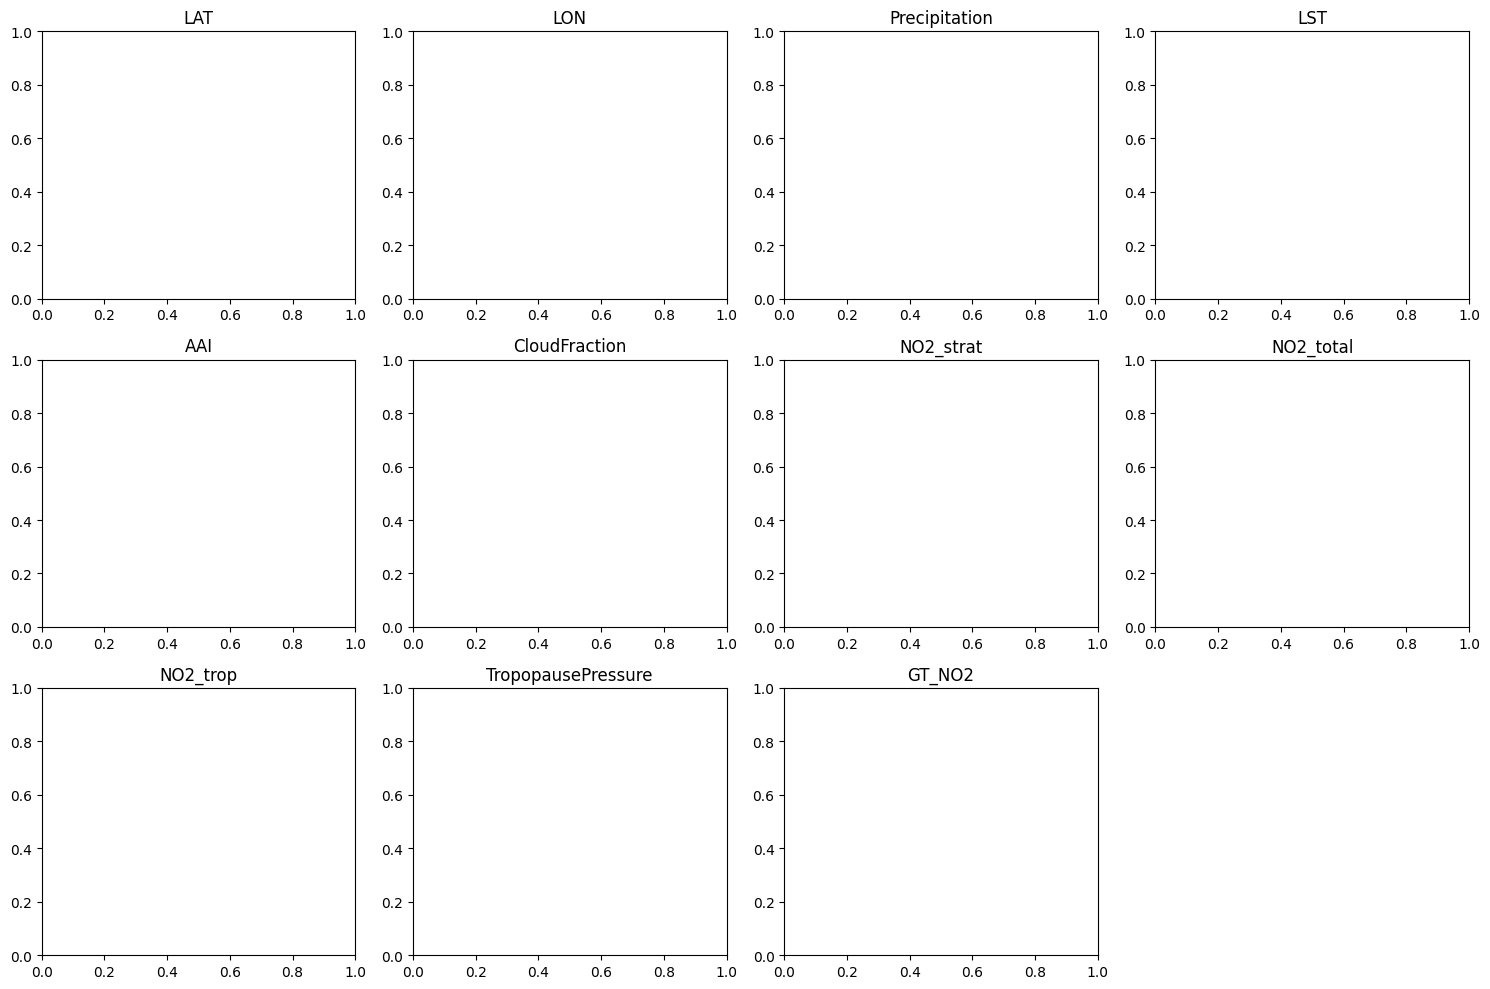

In [29]:
columns = [ 'LAT', 'LON', 'Precipitation', 'LST', 'AAI','CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop',
           'TropopausePressure', 'GT_NO2']
num_plots = len(columns)
n_cols = 4
n_rows = (num_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(columns):
    # sns.kdeplot(x=train1[col], ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [30]:
from sklearn.cluster import KMeans
a= KMeans(n_clusters=3,random_state=11,n_init=20).fit(np.array(train1['GT_NO2']).reshape(-1,1))
train1['labels'] = a.labels_

## FEATURE ENGINEERING

### INTERACTION FEATURES

In [31]:

#train1.shape #9.610818027153803

train1['LST_AAI_Interaction'] = train1['LST'] * train1['AAI']
#9.610938077090761

train1['AAI_NO2_Interaction'] = train1['AAI'] * train1['NO2_total']
#9.610567499271571

train1['AAI_Cloud_Ratio'] = train1['AAI'] / (train1['CloudFraction'] + 1e-6)
#9.60754193444533

train1['Cloud_NO2_Ratio'] = train1['CloudFraction'] / (train1['NO2_total'] + 1e-6)
#9.610027746463313

train1['NO2_LST_Interaction'] = train1['NO2_total'] * train1['LST']
#9.56788499698071

train1['Cloud_Albedo_Effect'] = train1['CloudFraction'] * train1['LST']
#9.609206210726136

train1['LSTsqr'] = train1['LST'] ** 3

### removed some features
train1['SUS'] = (train1['NO2_trop'] + train1['NO2_strat'] ) / train1['NO2_total']
train1['SUS_LST_Interaction'] = train1['SUS'] * train1['LST']

train1['AAI_sqr_log'] = np.log10(train1['AAI']**2)
train1['NO2_total_log'] = np.log10(train1['NO2_total'] + 0.0001 )
train1['NO2_trop_log'] = np.log10((train1['NO2_trop'] +0.001) ** 0.5)
train1['CloudFraction_log'] = np.log10(train1['CloudFraction'] + 0.001)
train1['NO2_strat_cub'] = np.log10(train1['NO2_strat']**3)

print(train1.shape)

(82545, 32)


In [32]:
percentageMissing(train1)

,Percentage missing (%)


### CLUSTERS

### "TIME SERIES" (HELP!!!)

In [33]:
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume train is the original DataFrame
train1 = train1.copy()  # Make a copy of train to perform operations on

numeric_columns = ['LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure','LST_AAI_Interaction',
       'AAI_NO2_Interaction', 'AAI_Cloud_Ratio', 'Cloud_NO2_Ratio',
       'NO2_LST_Interaction', 'Cloud_Albedo_Effect', 'LSTsqr', 'SUS',
       'SUS_LST_Interaction','AAI_sqr_log','NO2_total_log','NO2_trop_log','CloudFraction_log','NO2_strat_cub']   # Adjust this to your actual numeric columns

for col in numeric_columns:
    # Fill missing values temporarily using linear interpolation
    data_interpolated = train1[col].interpolate(method='linear')
    
    # Handle cases where interpolation might still leave NaNs at the ends
    if data_interpolated.isna().sum() > 0:
        data_interpolated.fillna(method='bfill', inplace=True)
        data_interpolated.fillna(method='ffill', inplace=True)

    # Decompose the time series to extract the trend component
    decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
    trend = decomposition.trend
    
    # Handle cases where the trend might still have NaNs at the ends
    trend.fillna(method='bfill', inplace=True)
    trend.fillna(method='ffill', inplace=True)

    # Replace original NaN values with the trend component
    train1[col] = train1[col].combine_first(trend)
    
    # Fill any remaining NaN values with the mean of the column
    train1[col].fillna(value=train1[col].mean(), inplace=True)

# Define the rolling window size (e.g., 3 days)
window_size = 3

# Exclude the 'Date' column from rolling calculations
rolling_numeric_columns = train1[numeric_columns]

# Calculate rolling mean for each numeric feature
train1_rolling_mean = rolling_numeric_columns.rolling(window=window_size).mean()

# Calculate rolling standard deviation for each numeric feature
train1_rolling_std = rolling_numeric_columns.rolling(window=window_size).std()

# Rename the columns to indicate they are rolling statistics
train1_rolling_mean.columns = [f'{col}_rolling_mean MON' for col in train1_rolling_mean.columns]
train1_rolling_std.columns = [f'{col}_rolling_std MON' for col in train1_rolling_std.columns]

train1_rolling_mean.fillna(method='ffill', inplace=True)
train1_rolling_mean.fillna(method='bfill', inplace=True)

train1_rolling_std.fillna(method='ffill', inplace=True)
train1_rolling_std.fillna(method='bfill', inplace=True)
# Concatenate the rolling statistics with the original dataframe
train1 = pd.concat([train1, train1_rolling_mean, train1_rolling_std], axis=1)



In [34]:
print(train1.shape)

(82545, 74)


In [35]:
train1 = pd.get_dummies(train1, columns=['Day' ,'Month','Week','Year','labels','Season','AAI_cat'], prefix=['Day', 'Month','Week','Year','labels','Season','AAI'], drop_first=False)

### SCALING AND DATA SELECTION

In [36]:
to_scale= ['LST','AAI','CloudFraction','NO2_strat','NO2_total','NO2_trop','TropopausePressure','LST_AAI_Interaction',
'AAI_NO2_Interaction','AAI_Cloud_Ratio','Cloud_NO2_Ratio','NO2_LST_Interaction','Cloud_Albedo_Effect','LSTsqr','SUS',
'SUS_LST_Interaction','LST_rolling_mean MON','AAI_rolling_mean MON','CloudFraction_rolling_mean MON',
'NO2_strat_rolling_mean MON','NO2_total_rolling_mean MON','NO2_trop_rolling_mean MON','TropopausePressure_rolling_mean MON',
'LST_AAI_Interaction_rolling_mean MON','AAI_NO2_Interaction_rolling_mean MON','AAI_Cloud_Ratio_rolling_mean MON',
'Cloud_NO2_Ratio_rolling_mean MON','NO2_LST_Interaction_rolling_mean MON','Cloud_Albedo_Effect_rolling_mean MON',
'LSTsqr_rolling_mean MON','SUS_rolling_mean MON','SUS_LST_Interaction_rolling_mean MON','LST_rolling_std MON',
'AAI_rolling_std MON','CloudFraction_rolling_std MON','NO2_strat_rolling_std MON','NO2_total_rolling_std MON',
'NO2_trop_rolling_std MON','TropopausePressure_rolling_std MON','LST_AAI_Interaction_rolling_std MON',
'AAI_NO2_Interaction_rolling_std MON','AAI_Cloud_Ratio_rolling_std MON','Cloud_NO2_Ratio_rolling_std MON',
'NO2_LST_Interaction_rolling_std MON','Cloud_Albedo_Effect_rolling_std MON','LSTsqr_rolling_std MON','SUS_rolling_std MON',
'SUS_LST_Interaction_rolling_std MON','AAI_sqr_log_rolling_std MON', 'NO2_total_log_rolling_std MON',
'NO2_trop_log_rolling_std MON','CloudFraction_log_rolling_std MON','NO2_strat_cub_rolling_std MON',
'AAI_sqr_log_rolling_mean MON','NO2_total_log_rolling_mean MON','NO2_trop_log_rolling_mean MON',
'CloudFraction_log_rolling_mean MON','NO2_strat_cub_rolling_mean MON','AAI_sqr_log','NO2_total_log','NO2_trop_log','CloudFraction_log','NO2_strat_cub']

In [37]:
x1 = train1.drop(['GT_NO2','LAT','Precipitation','labels_1','labels_2'],axis=1) 

from sklearn.preprocessing import StandardScaler
columns_to_scale = x1[to_scale]
x1 = x1.drop(to_scale,axis=1)
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(columns_to_scale)


x1 = np.concatenate([scaled_columns, x1], axis=1)
y1 = np.array(train1['GT_NO2'])
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.25,random_state=15)
x1_train.shape,y1_test.shape


((61908, 124), (20637,))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x1,y1,test_size=0.25,random_state=15)

## Polynomial Regression

In [40]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import root_mean_squared_error, r2_score

# degree = 2 

# poly = PolynomialFeatures(degree)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)

# model = LinearRegression()
# model.fit(X_train_poly, y_train)

# y_train_pred = model.predict(X_train_poly)
# y_test_pred = model.predict(X_test_poly)

# # Evaluate the model
# train_rmse = root_mean_squared_error(y_train, y_train_pred)
# test_rmse = root_mean_squared_error(y_test, y_test_pred)
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# # Display the results
# print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
# print()
# print(f"Train R^2: {train_r2:.2f}, Test R^2: {test_r2:.2f}")


##### Linear regression : 9.35571 *test set performance.*

*Data preprocessing steps:*
- *Knn imputation* (n_neighbors=3) *training and test*.
- *One hot encoding Year,Month,Day,and week*
- Z-score normalization cut off 2
- created:'Precip_LST_Ratio',
       'Precip_Cloud_Ratio', 'LST_AAI_Interaction', 'AAI_NO2_Interaction',
       'AAI_Cloud_Ratio', 'Cloud_NO2_Ratio', 'NO2_LST_Interaction',
       'Cloud_Albedo_Effect', 'LSTsqr', 'Precipitationsqr'

In [40]:
lreg1 = LinearRegression()
lreg1.fit(x1_train, y1_train)
linear_preds = lreg1.predict(x1_test)
rmse = rmse(y1_test,linear_preds)
print(rmse)

9.276667512686801


In [41]:
9.28292381524062

9.28292381524062

# Test data preprocessing 

In [42]:
new_df = pd.DataFrame(test_data['ID_Zindi'])
test1 = test_data
test1 = test1.drop(['ID','ID_Zindi','Date'],axis = 1)
test1.shape

test1 = test1.interpolate(method='linear')

# Fill any remaining NaNs with forward-fill and backward-fill
test1 = test1.ffill().bfill()


test1['LST_AAI_Interaction'] = test1['LST'] * test1['AAI']
#print(test1.shape)  # 9.610938077090761

test1['AAI_NO2_Interaction'] = test1['AAI'] * test1['NO2_total']
#print(test1.shape)  # 9.610567499271571

test1['AAI_Cloud_Ratio'] = test1['AAI'] / (test1['CloudFraction'] + 1e-6)
print(test1.shape)  # 9.60754193444533

test1['Cloud_NO2_Ratio'] = test1['CloudFraction'] / (test1['NO2_total'] + 1e-6)
#print(test1.shape)  # 9.610027746463313

test1['NO2_LST_Interaction'] = test1['NO2_total'] * test1['LST']
print(test1.shape)  # 9.56788499698071

test1['Cloud_Albedo_Effect'] = test1['CloudFraction'] * test1['LST']
print(test1.shape)  # 9.609206210726136
test1['LSTsqr'] = test1['LST'] ** 3
#test1['Precipitationsqr'] = test1['Precipitation'] ** 2

test1['SUS'] = (test1['NO2_trop'] + test1['NO2_strat'] ) / test1['NO2_total']
test1['SUS_LST_Interaction'] = test1['SUS'] * test1['LST']
#test1['ehn'] = test1['NO2_trop'] / test1['NO2_strat']


test1['AAI_sqr_log'] = np.log10(test1['AAI']**2)
test1['NO2_total_log'] = np.log10(test1['NO2_total'] + 0.0001 )
test1['NO2_trop_log'] = np.log10((test1['NO2_trop'] +0.001) ** 0.5)
test1['CloudFraction_log'] = np.log10(test1['CloudFraction'] + 0.001)
test1['NO2_strat_cub'] = np.log10(test1['NO2_strat']**3)

from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Assume test1 is the original DataFrame
test1 = test1.copy()  # Make a copy of test1 to perform operations on

# Define your numeric columns
numeric_columns = ['LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure','LST_AAI_Interaction',
       'AAI_NO2_Interaction', 'AAI_Cloud_Ratio', 'Cloud_NO2_Ratio',
       'NO2_LST_Interaction', 'Cloud_Albedo_Effect', 'LSTsqr', 'SUS',
       'SUS_LST_Interaction','AAI_sqr_log','NO2_total_log','NO2_trop_log','CloudFraction_log','NO2_strat_cub']
# Decomposition and Trend Extraction
for col in numeric_columns:
    # Fill missing values temporarily using linear interpolation
    data_interpolated = test1[col].interpolate(method='linear')
    
    # Handle cases where interpolation might still leave NaNs at the ends
    if data_interpolated.isna().sum() > 0:
        data_interpolated.fillna(method='bfill', inplace=True)
        data_interpolated.fillna(method='ffill', inplace=True)

    # Decompose the time series to extract the trend component
    decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
    trend = decomposition.trend
    
    # Handle cases where the trend might still have NaNs at the ends
    trend.fillna(method='bfill', inplace=True)
    trend.fillna(method='ffill', inplace=True)

    # Replace original NaN values with the trend component
    test1[col] = test1[col].combine_first(trend)
    
    # Fill any remaining NaN values with the mean of the column
    test1[col].fillna(value=test1[col].mean(), inplace=True)

# Define the rolling window size (e.g., 30 days)
window_size = 3

# Calculate rolling mean and standard deviation for each numeric feature
test1_rolling_mean = test1[numeric_columns].rolling(window=window_size).mean()
test1_rolling_std = test1[numeric_columns].rolling(window=window_size).std()

# Rename the columns to indicate they are rolling statistics
test1_rolling_mean.columns = [f'{col}_rolling_mean MON' for col in test1_rolling_mean.columns]
test1_rolling_std.columns = [f'{col}_rolling_std MON' for col in test1_rolling_std.columns]

# Fill NaN values in the rolling statistics using forward and backward fill
test1_rolling_mean.fillna(method='ffill', inplace=True)
test1_rolling_mean.fillna(method='bfill', inplace=True)
test1_rolling_std.fillna(method='ffill', inplace=True)
test1_rolling_std.fillna(method='bfill', inplace=True)

# Concatenate the rolling statistics with the original DataFrame
test1 = pd.concat([test1, test1_rolling_mean, test1_rolling_std], axis=1)
print(test1.shape)


# Now, test1 includes the trend-replaced features and the rolling statistics.



(6576, 19)
(6576, 21)
(6576, 22)
(6576, 72)


In [43]:
label_df = test1[to_predict_labels]

columns_to_scale = label_df.drop(columns_to_exclude,axis=1)
scaled_columns = scaler1.transform(columns_to_scale)

columns_excluded = label_df[columns_to_exclude]
#columns_excluded = pd.get_dummies(columns_excluded, columns=['Season'], prefix=['Season'], drop_first=False)
label_df = np.concatenate([scaled_columns, columns_excluded.values], axis=1)

test_labels = dtc.predict(label_df)
test1['labels'] = test_labels


In [44]:
test1 = pd.get_dummies(test1, columns=['Day','Month','Week','Year','labels','Season','AAI_cat'], prefix=['Day', 'Month','Week','Year','labels','season','AAI'], drop_first=False)

In [45]:
print(test1.shape)

(6576, 128)


In [46]:

test1 = test1.drop(['LAT',"Precipitation",'labels_1','labels_2'],axis=1)
columns_to_scale =  test1[to_scale]
test1 = test1.drop(to_scale,axis=1)
scaled_columns = scaler.transform(columns_to_scale)
test1 = np.concatenate([scaled_columns, test1], axis=1)

GT_NO2 = lreg1.predict(test1)
new_df['GT_NO2'] = GT_NO2
new_df.head(50)

,ID_Zindi,GT_NO2
0,ID_2MYNQS,33.411102
1,ID_P4U5WU,39.085862
2,ID_U4KWPK,41.739182
3,ID_QGSNTZ,38.378192
4,ID_GHSZ6K,34.113015
5,ID_NKPFFW,37.629180
6,ID_Z9ICW9,25.078840
7,ID_H2YFI6,19.256184
8,ID_RMBWWV,24.858628
9,ID_8JASJD,31.952000


In [47]:
new_df.to_csv('./try.csv',index=False)

In [48]:
test1.shape

(6576, 124)

## XG Boost

In [54]:
from xgboost import XGBRegressor

In [55]:
xg = XGBRegressor()
xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
y_test

array([26.6  ,  7.725, 20.   , ..., 28.   , 20.1  , 28.   ])

In [59]:
prd = xg.predict(X_test)

In [60]:
prd

array([20.715216, 10.755006, 23.186106, ..., 27.854282, 22.676886,
       27.350477], dtype=float32)

In [61]:
from sklearn.metrics import root_mean_squared_error as rmsea
rmsea(y_test, prd)

6.062924433691159

In [62]:
y_pred = xg.predict(test1)

In [66]:
z = pd.read_csv('Test.csv')
xg_df = pd.DataFrame({
    'ID_Zindi': z['ID_Zindi'],
    'GT_NO2': y_pred
})

In [67]:
xg_df.to_csv('xg_long.csv', index=False)

In [68]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [70]:
pred = svr.predict(X_test)
print(rmsea(y_test, pred))
y_pred = svr.predict(test1)
svr_df = pd.DataFrame({
    'ID_Zindi': z['ID_Zindi'],
    'GT_NO2': y_pred
})
svr_df.to_csv('svr_long.csv', index=False)

8.321665144747838


In [71]:
pred = svr.predict(X_train)
print(rmsea(y_train, pred))

8.046598355975394


In [49]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime 

In [50]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8000      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10113 (39.50 KB)
Trainable params: 10113 (39.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [54]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [55]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, 
    callbacks=[early_stopping_callback]
)

Epoch 1/100


1935/1935 [==============================] - 3s 1ms/step - loss: 99.6949 - mse: 99.6949 - val_loss: 69.4961 - val_mse: 69.4961
Epoch 2/100
1935/1935 [==============================] - 2s 1ms/step - loss: 65.0675 - mse: 65.0675 - val_loss: 66.5049 - val_mse: 66.5049
Epoch 3/100
1935/1935 [==============================] - 2s 1ms/step - loss: 62.6293 - mse: 62.6293 - val_loss: 64.2647 - val_mse: 64.2647
Epoch 4/100
1935/1935 [==============================] - 2s 1ms/step - loss: 61.1148 - mse: 61.1148 - val_loss: 63.3045 - val_mse: 63.3045
Epoch 5/100
1935/1935 [==============================] - 2s 1ms/step - loss: 60.1554 - mse: 60.1554 - val_loss: 64.1659 - val_mse: 64.1659
Epoch 6/100
1935/1935 [==============================] - 2s 1ms/step - loss: 58.9041 - mse: 58.9041 - val_loss: 62.0855 - val_mse: 62.0855
Epoch 7/100
1935/1935 [==============================] - 2s 1ms/step - loss: 58.1851 - mse: 58.1851 - val_loss: 60.9355 - val_mse: 60.9355
Epoch 8/100
1935/1935 [==

In [56]:
test_loss,test_mse = model.evaluate(X_test, y_test)
print(f'Test RMAE: {np.sqrt(test_mse)}')

645/645 [==============================] - 1s 770us/step - loss: 57.0566 - mse: 57.0566
Test RMAE: 7.553579823219713


In [57]:
test_loss,test_mse = model.evaluate(X_train, y_train)
print(f'Test RMAE: {np.sqrt(test_mse)}')

1935/1935 [==============================] - 2s 800us/step - loss: 47.3707 - mse: 47.3707
Test RMAE: 6.882638190808534


In [82]:
test1 = np.array(test1, dtype=np.float32)

In [83]:
y_pred = model.predict(test1)

206/206 [==============================] - 0s 867us/step


In [84]:
output_df = pd.DataFrame({
    'ID_ZINDI': z['ID_Zindi'],
    'GT_NO2': y_pred.flatten()
})

In [85]:
output_df.to_csv('./tens_long.csv', index=False)

In [1]:
from sklearn.linear_model import RANSACRegressor
q = RANSACRegressor()
q.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [88]:
pred = q.predict(X_test)
print(rmsea(y_test, pred))
y_pred = q.predict(test1)
svr_df = pd.DataFrame({
    'ID_Zindi': z['ID_Zindi'],
    'GT_NO2': y_pred
})
svr_df.to_csv('svr_long.csv', index=False)

32.16782
